In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
import numpy as np

from skimage import data
from skimage.transform import resize
from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch_fidelity import calculate_metrics

# from src.autoencoder import ViTEncoder as Encoder, ViTDecoder as Decoder
from src.vqgan import ViTVQ

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image = data.coffee()
image_resized = resize(image, (256, 256), anti_aliasing=True)
input_data = (
	torch.tensor(image_resized).permute(2, 0, 1).unsqueeze(0).float().to(device)
)
image.shape, image_resized.shape, input_data.shape

((400, 600, 3), (256, 256, 3), torch.Size([1, 3, 256, 256]))

In [ ]:
# initialize ViT-VQGAN
image_size = None
patch_size = None

model_size = "small"  # small/base
# vitvq = ViTVQ(
#     image_size=256, patch_size=8,
#     dim=512, mlp_dim=2048, depth=8, heads=8,
#     n_codes=8192, quant_dim=32
# )  # small
# vitvq.to(device)
vitvq = ViTVQ(
    image_size=256, patch_size=8,
    dim=768, mlp_dim=3072, depth=12, heads=12,
    n_codes=8192, quant_dim=32
)  # base
vitvq.to(device)
# vitvq = ViTVQ(
#     image_size=256, patch_size=8,
#     dim=768, mlp_dim=3072, depth=12, heads=12,
#     n_codes=8192, quant_dim=32
# )  # base
# vitvq.to(device)

vitvq.init_from_ckpt(f"./checkpoint/imagenet_vitvq_{model_size}.ckpt")
vitvq.eval()
print()

Restored from ./checkpoint/imagenet_vitvq_base.ckpt



In [ ]:
with torch.no_grad():
	# encoding
	quant, diff, codes = vitvq.encode(input_data)
	# decoding
	output = vitvq.decode(quant)
	output_image = output.squeeze(0).permute(1, 2, 0).cpu().numpy()
output_image = output_image.clip(0, 1)

print(quant.shape, codes.shape, output_image.shape)

torch.Size([1, 1024, 32]) (256, 256, 3)


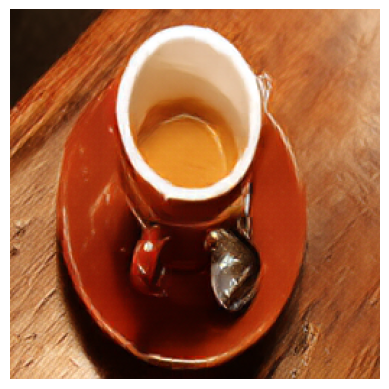

In [14]:
plt.imshow(output_image)
plt.axis("off")
plt.show()

In [ ]:
def save_images(images, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i, img in enumerate(images):
        img = (img * 255).astype(np.uint8)  # Convert to uint8
        Image.fromarray(img).save(os.path.join(directory, f"image_{i:04d}.png"))

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "./output/input_images" with extensions png,jpg,jpeg
Found 1 samples
Processing samples                                                    
Extracting statistics from input 2
Looking for samples non-recursivelty in "./output/output_images" with extensions png,jpg,jpeg
Found 1 samples
Processing samples                                                    
Frechet Inception Distance: 50.00193932587713


FID Score: 50.00193932587713


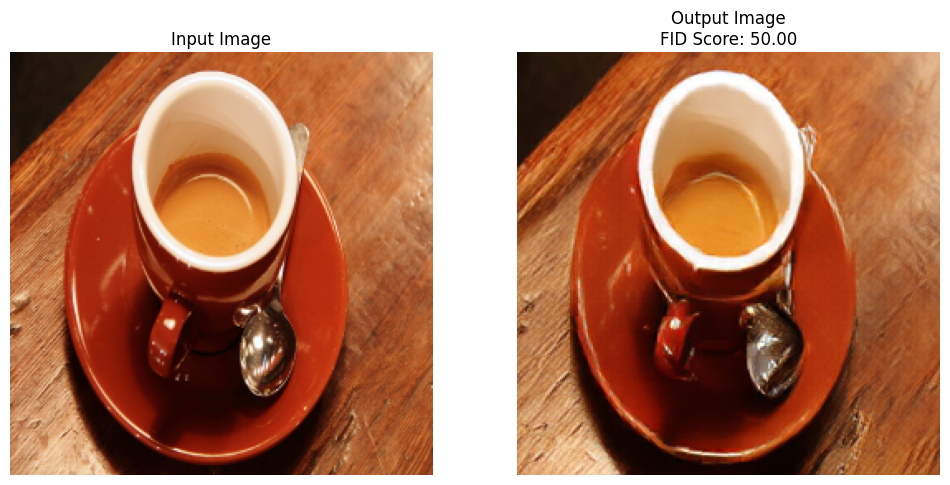

In [16]:

save_images([image_resized], "./output/input_images")
save_images([output_image], "./output/output_images")

fid_result = calculate_metrics(
	input1="./output/input_images",
	input2="./output/output_images",
	cuda=torch.cuda.is_available(),
	isc=False,
	fid=True,
)

fid_score = fid_result["frechet_inception_distance"]
print(f"FID Score: {fid_score}")

# Plot the input and output images with FID score
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_resized)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(output_image)
axes[1].set_title(f"Output Image\nFID Score: {fid_score:.2f}")
axes[1].axis("off")
plt.savefig("imgs/base.png")
plt.show()

# Clean up
shutil.rmtree("./output/input_images")
shutil.rmtree("./output/output_images")